<a href="https://colab.research.google.com/github/WCSCourses/Single_Cell_Genomics_ImmuneSys_24/blob/main/modules/Module1_scRNAseq/scRNAseq_Workshop_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.wellcomeconnectingscience.org/wp-content/themes/new_wellcome_connecting_science/dist/assets/svg/logo.svg" alt="WCS Logo" width="150" style="float: left;">
<img src="https://github.com/EveliaCoss/Tutorial_ISCB_LATAM_scATACseq/blob/main/Logo_JAGUAR.png?raw=true" alt="WCS Logo" width="150" style="float: right;">





<h1><center>

# **Single-Cell RNA-seq Workshop: Solutions and Explanations**

<h1></center>

In this notebook, we provide detailed solutions and explanations for the activities presented in the Single-Cell RNA-seq Workshop.
This document will guide you through the correct answers, illustrating key concepts and methods in single-cell RNA sequencing analysis.

## About the course 📌

This course is part of the Workshop [Single Cell Genomic Approaches to Study the Immune System - Latin America & the Caribbean](https://coursesandconferences.wellcomeconnectingscience.org/event/single-cell-genomic-approaches-to-study-the-immune-system-latin-america-the-caribbean-20241109/) (9-11 Novembrer 2024), Universidad CES, Medellín, Colombia.

- **Date:** 9 November 2024
- **Course duration**: 7 hours

**Speakers:**
- <font color='orange'>Benilton Carvalho</font> - PhD in Biostatistics. Associate Professor and Department Chair of Campinas State University. São Paulo, Brazil
- <font color='orange'>Julieth López</font> - PhD student in Biotechnology, National University of Colombia, Bogotá, Colombia. Employed as PhD student in Colombian institute of tropical medicine (ICMT), Health Studies Corporation (CES), Medellín, Colombia. [Web page](https://www.linkedin.com/in/julieth-andrea-lopez/)

**Abstract:** Single-cell ribonucleic acid sequencing (scRNA-seq) is a modern technology used to study the transcriptome of a cell, providing an exhaustive view of gene expression, which allows to get insights into cellular function. It is the most advanced biotechnological method in the single-cell field, enabling the examination of the entire RNA content within a cell. This tutorial will explain the general characteristics of single-cell data and will offer a computational practice over open data to understand the workflow analysis of scRNA-seq data.

**Learning objectives:**
1. Understand of single-cell data structure in Seurat
2. Implement of scRNA-seq pre-processing and quality control
3. Recognize importance of data normalization
4. Perform dimensionality reduction and clustering
5. Explore automated cell annotation approaches
6. Comprehend utility of differential gene expression, application between clusters

If you want to come back to the Github, please follow the next link:
*   Github: https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24


<center>

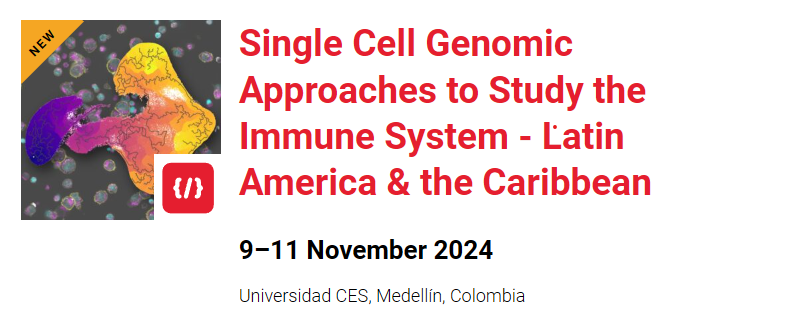

</center>

# 🎮 **Activities solutions**

## Activity 1 : Exploring Differential Gene Expression Analysis Methods


In [ ]:
# Solution for Task 1: Identify DEGs using the default Wilcoxon Rank Sum test
all_DEGs_wilcox <- FindAllMarkers(sampleA, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1.5)

# Display the top differentially expressed genes
cat("Top differentially expressed genes using Wilcoxon test:\n")
print(head(all_DEGs_wilcox))

ERROR: Error in FindAllMarkers(sampleA, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1.5): could not find function "FindAllMarkers"


The Wilcoxon Rank Sum test is the default method used by Seurat to identify differentially expressed genes (DEGs) across clusters.
This non-parametric test is robust and commonly used in scRNA-seq analysis.


### Task 1: Modify the Method - t-test



In [ ]:
# Solution for Task 2: Identify DEGs using the t-test
all_DEGs_ttest <- FindAllMarkers(sampleA, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1.5, test.use = 't')

# Display the top differentially expressed genes
cat("Top differentially expressed genes using t-test:\n")
print(head(all_DEGs_ttest))


ERROR: Error in FindAllMarkers(sampleA, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1.5, : could not find function "FindAllMarkers"


The t-test is another method for identifying DEGs, which assumes that the data follows a normal distribution.
It is often used when comparing two groups and provides an alternative to the Wilcoxon test.


### Task 2: Explore DESeq2 Method

In [ ]:
# Ensure DESeq2 is installed and loaded
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

DESeq2 is a popular method for differential expression analysis, particularly in bulk RNA-seq.
In scRNA-seq, its application can be challenging due to the sparsity of the data, but it provides valuable insights in certain contexts.


In [ ]:
all_DEGs_DESeq2 <- FindMarkers(sampleA, ident.1 = "0", ident.2 = "1", test.use = 'DESeq2', min.pct = 0.25, logfc.threshold = 0)
head(all_DEGs_DESeq2)


### Comparison table

In [ ]:
# Identify DEGs using the default Wilcoxon Rank Sum Test
all_DEGs_wilcox <- FindAllMarkers(sampleA, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1.5)

# Identify DEGs using the t-test
all_DEGs_ttest <- FindAllMarkers(sampleA, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1.5, test.use = 't')

# Select the top 10 DEGs from each method for comparison
top_wilcox <- all_DEGs_wilcox %>% top_n(n = 20, wt = avg_log2FC)
top_ttest <- all_DEGs_ttest %>% top_n(n = 20, wt = avg_log2FC)

# Create a comparison table
comparison_table <- data.frame(
  Gene = top_wilcox$gene,
  Wilcoxon_LogFC = top_wilcox$avg_log2FC,
  Wilcoxon_p_val = top_wilcox$p_val_adj,
  TTest_LogFC = top_ttest$avg_log2FC[match(top_wilcox$gene, top_ttest$gene)],
  TTest_p_val = top_ttest$p_val_adj[match(top_wilcox$gene, top_ttest$gene)]
)

# Print the comparison table
print(comparison_table)


## Activity 2: Differential Gene Expression Analysis with PBMC Data

In this activity, you'll work with PBMC single-cell RNA-seq data from SeuratData. These reference data (pbmc3k) are commonly used to demonstrate single-cell RNA-seq workflows. You'll explore the data, perform quality control, normalize, scale, identify and remove doublets, and annotate cell types before identifying differentially expressed genes across clusters.



### 1. Load and Explore the Data

In [ ]:
library("SeuratData") #data reference PBMC
AvailableData()
# Load the PBMC dataset
InstallData("pbmc3k")
pbmc <- UpdateSeuratObject(pbmc3k)

Exploring the Data

In [ ]:
# Data exploration
data_counts_pbmc3k <- as.matrix(pbmc@assays$RNA@counts)
dim(data_counts_pbmc3k)

In [ ]:
## Dimensions of the scRNA-seq matrix
dims <- dim(data_counts_pbmc3k)
num_genes <- dims[1]
num_cells <- dims[2]
cat("The dataset contains", num_genes, "genes and", num_cells, "cells.\n")
cat("Matrix class:", class(pbmc), "\n")

### 2. Quality Control (QC)

The pbmc3k dataset is already provided as a Seurat object, so we can directly perform QC.

In [ ]:
# Calculate the percentage of mitochondrial genes
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
# Quality control with violin plots
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [ ]:
# Set plot size
options(repr.plot.width = 12, repr.plot.height = 8)
## Scatter plots for visual inspection of relationships between metrics
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [ ]:
## Subset the Seurat object to exclude cells with high mitochondrial content
#Filter cells based on RNA features and mitochondrial content.
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

Identify and Remove Doublets:

In [ ]:
# Identify and remove doublets
library(scDblFinder)
sce <- as.SingleCellExperiment(pbmc)
sce <- scDblFinder(sce)
pbmc$doublet_score <- colData(sce)$scDblFinder.score
pbmc$doublet_label <- colData(sce)$scDblFinder.class
pbmc <- subset(pbmc, subset = doublet_label == "singlet")
head(pbmc@meta.data)

### 3. Normalize the data

Normalize the data, identify the top variable genes and scale the data.

In [ ]:
# Normalize the data
pbmc <- NormalizeData(pbmc)

### 4. Identify variable genes

In [ ]:
# Identify highly variable features
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

## Display top 15 variable genes
top10 <- head(VariableFeatures(pbmc), 15)
print(top10)


In [ ]:
## Plot variable features with labels
plot1 <- VariableFeaturePlot(pbmc)
LabelPoints(plot=plot1, points = top10, repel=T, xnudge=0, ynudge=0) + theme(legend.position="none")

Scale the Data:

In [ ]:
# Scale the data
pbmc <- ScaleData(pbmc, features = rownames(pbmc))

### 5. Dimensionality Reduction and Clustering

Perform PCA, followed by UMAP for visualization. Use FindNeighbors and FindClusters to cluster the cells.

In [ ]:
# Perform PCA
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
DimPlot(pbmc, reduction = "pca")

In [ ]:
ElbowPlot(pbmc, ndims=30)

In [ ]:
# Run UMAP and clustering
pbmc <- RunUMAP(pbmc, dims = 1:12,verbose=F)
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

In [ ]:
# Visualize the clusters using UMAP
DimPlot(pbmc, reduction = "umap", group.by = "seurat_clusters")

### 6. Differential Expression

Identify differentially expressed genes across clusters using the Wilcoxon test

In [ ]:
#install.packages('devtools')
#devtools::install_github('immunogenomics/presto')

In [ ]:
# Identify differentially expressed genes
all_DEGs_PBMC <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1.5)

# Display top differentially expressed genes
print(head(all_DEGs_PBMC,20))

### 7. Cell Type Annotation

Annotate cell types using SingleR with a reference dataset.
Visualize the annotated cell types on a UMAP plot.

In [ ]:
# Perform cell type annotation using SingleR
library(SingleR)
library(celldex)

In [ ]:
annotations <- SingleR(test = sce, ref = ref, labels = ref$label.main)
pbmc$cell_type <- annotations$labels

## Display a table with the count of cells assigned to each cell type
cat("Cell type annotation counts:\n")
print(table(pbmc$cell_type))

In [ ]:
# Visualize the annotated cell types
DimPlot(pbmc, reduction = "umap", group.by = "cell_type")